In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
import warnings
import time
import math

# Unicode warning 제거 (폰트 관련 경고메시지)
plt.rcParams['axes.unicode_minus']=False
# 한글 폰트 설정
plt.rcParams['font.family'] = "NanumGothic"

warnings.filterwarnings('ignore')

data_dir = 'data'

# ChatbotData.csv가 있는 구글 드라이브 경로 지정
CSV_PATH = "ChatbotData.csv"

df = pd.read_csv('ChatbotData.csv')
df

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
question = df['Q']
answer = df['A']

In [4]:
question[:5]

0             12시 땡!
1        1지망 학교 떨어졌어
2       3박4일 놀러가고 싶다
3    3박4일 정도 놀러가고 싶다
4            PPL 심하네
Name: Q, dtype: object

In [5]:
answer[:5]

0     하루가 또 가네요.
1      위로해 드립니다.
2    여행은 언제나 좋죠.
3    여행은 언제나 좋죠.
4     눈살이 찌푸려지죠.
Name: A, dtype: object

## 1. 데이터 전처리

### 1-1. 한글 정규화

In [6]:
import re

# 한글, 영어, 숫자, 공백, ?!.,을 제외한 나머지 문자 제거
korean_pattern = r'[^ ?,.!A-Za-z0-9가-힣+]'

# 패턴 컴파일
normalizer = re.compile(korean_pattern)
normalizer

re.compile(r'[^ ?,.!A-Za-z0-9가-힣+]', re.UNICODE)

In [7]:
print(f'수정 전: {question[10]}')
print(f'수정 후: {normalizer.sub("", question[10])}')

수정 전: SNS보면 나만 빼고 다 행복해보여
수정 후: SNS보면 나만 빼고 다 행복해보여


In [8]:
print(f'수정 전: {answer[10]}')
print(f'수정 후: {normalizer.sub("", answer[10])}')

수정 전: 자랑하는 자리니까요.
수정 후: 자랑하는 자리니까요.


In [10]:
def normalize(sentence):
    return normalizer.sub("", sentence)

normalize(question[10])

'SNS보면 나만 빼고 다 행복해보여'

### 1-2. 한글 형태소 분석기

In [11]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 47.6 MB/s eta 0:00:00


In [12]:
from konlpy.tag import Okt

# 형태소 분석기
okt = Okt()

In [13]:
# okt
okt.morphs(normalize(answer[10]))

['자랑', '하는', '자리', '니까', '요', '.']

In [14]:
# 한글 전처리를 함수화
def clean_text(sentence, tagger):
    sentence = normalize(sentence)
    sentence = tagger.morphs(sentence)
    sentence = ' '.join(sentence)
    sentence = sentence.lower()
    return sentence

In [15]:
# 한글
clean_text(question[10], okt)

'sns 보면 나 만 빼고 다 행복 해보여'

In [16]:
# 영어
clean_text(answer[10], okt)

'자랑 하는 자리 니까 요 .'

In [17]:
len(question), len(answer)

(11823, 11823)

In [18]:
#1000개만 전처리
questions = [clean_text(sent, okt) for sent in question.values[:1000]]
answers = [clean_text(sent, okt) for sent in answer.values[:1000]]

In [19]:
questions[:5]

['12시 땡 !', '1 지망 학교 떨어졌어', '3 박 4일 놀러 가고 싶다', '3 박 4일 정도 놀러 가고 싶다', 'ppl 심하네']

In [20]:
answers[:5] # 잘 작동합니다

['하루 가 또 가네요 .',
 '위로 해 드립니다 .',
 '여행 은 언제나 좋죠 .',
 '여행 은 언제나 좋죠 .',
 '눈살 이 찌푸려지죠 .']

### 1-3. 단어 사전 생성

In [21]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [22]:
class WordVocab():
    def __init__(self):
        SOS_TOKEN = 0
        EOS_TOKEN = 1
        UNKNOWN_TOKEN = 2

        self.unknown_token = UNKNOWN_TOKEN

        # 각 토큰 별 word count
        self.word2count = {}

        # word -> idx
        self.word2index = {
            '<SOS>': SOS_TOKEN,
            '<EOS>': EOS_TOKEN,
            '<UKN>': UNKNOWN_TOKEN,
        }

        # idx -> word
        self.index2word = {
            SOS_TOKEN: '<SOS>',
            EOS_TOKEN: '<EOS>',
            UNKNOWN_TOKEN: '<UKN>',
        }

        # total word counts
        self.n_words = 3  # SOS, EOS, UNKNOWN 포함

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def word_to_index(self, word):
        if word in self.word2index:
            return self.word2index[word]
        else:
            return self.unknown_token

    def index_to_word(self, idx):
        return self.index2word[idx]

In [23]:
questions[10]

'sns 보면 나 만 빼고 다 행복 해보여'

In [24]:
print(f'원문: {questions[10]}')
wordvocab = WordVocab()
wordvocab.add_sentence(questions[10])
print('==='*10)
print('단어사전')
print(wordvocab.word2index)

원문: sns 보면 나 만 빼고 다 행복 해보여
단어사전
{'<SOS>': 0, '<EOS>': 1, '<UKN>': 2, 'sns': 3, '보면': 4, '나': 5, '만': 6, '빼고': 7, '다': 8, '행복': 9, '해보여': 10}


### 1-4. 전처리 프로세스를 클래스화

- 데이터를 로드하고, 정규화 및 전처리, 토큰화를 진행합니다.
- 단어 사전을 생성하고 이에 따라, 시퀀스로 변환합니다.

In [25]:
from konlpy.tag import Okt


class QADataset():
    def __init__(self, csv_path, min_length=3, max_length=25):

        # TOKEN 정의
        self.SOS_TOKEN = 0 # SOS 토큰
        self.EOS_TOKEN = 1 # EOS 토큰

        self.tagger = Okt()   # 형태소 분석기
        self.max_length = max_length # 한 문장의 최대 길이 지정

        # CSV 데이터 로드
        df = pd.read_csv(csv_path)

        # 한글 정규화
        korean_pattern = r'[^ ?,.!A-Za-z0-9가-힣+]'
        self.normalizer = re.compile(korean_pattern)

        # src: 질의, tgt: 답변
        src_clean = []
        tgt_clean = []

        # 단어 사전 생성
        wordvocab = WordVocab()

        for _, row in df.iterrows():
            src = row['Q']
            tgt = row['A']

            # 한글 전처리
            src = self.clean_text(src)
            tgt = self.clean_text(tgt)

            if len(src.split()) > min_length and len(tgt.split()) > min_length:
                # 최소 길이를 넘어가는 문장의 단어만 추가
                wordvocab.add_sentence(src)
                wordvocab.add_sentence(tgt)
                src_clean.append(src)
                tgt_clean.append(tgt)

        self.srcs = src_clean
        self.tgts = tgt_clean
        self.wordvocab = wordvocab


    def normalize(self, sentence):
        # 정규표현식에 따른 한글 정규화
        return self.normalizer.sub("", sentence)

    def clean_text(self, sentence):
        # 한글 정규화
        sentence = self.normalize(sentence)
        # 형태소 처리
        sentence = self.tagger.morphs(sentence)
        sentence = ' '.join(sentence)
        sentence = sentence.lower()
        return sentence

    def texts_to_sequences(self, sentence):
        # 문장 -> 시퀀스로 변환
        sequences = [self.wordvocab.word_to_index(w) for w in sentence.split()]
        # 문장 최대 길이 -1 까지 슬라이싱
        sequences = sequences[:self.max_length-1]
        # 맨 마지막에 EOS TOKEN 추가
        sequences.append(self.EOS_TOKEN)
        return sequences

    def sequences_to_texts(self, sequences):
        # 시퀀스 -> 문장으로 변환
        sentences = [self.wordvocab.index_to_word(s.item()) for s in sequences]
        return ' '.join(sentences)


    def __getitem__(self, idx):
        inputs = self.srcs[idx]
        inputs_sequences = self.texts_to_sequences(inputs)

        outputs = self.tgts[idx]
        outputs_sequences = self.texts_to_sequences(outputs)

        return torch.tensor(inputs_sequences).view(-1, 1), torch.tensor(outputs_sequences).view(-1, 1)

    def __len__(self):
        return len(self.srcs)

In [26]:
# 한 문장의 최대 단어길이를 25로 설정
MAX_LENGTH = 25

# 데이터셋 생성
dataset = QADataset(CSV_PATH, min_length=3, max_length=MAX_LENGTH)

In [27]:
# 3번 index 데이터셋 조회
# 결과: x(입력 데이터), y(출력 데이터)
dataset[3]

(tensor([[22],
         [23],
         [24],
         [25],
         [ 1]]),
 tensor([[26],
         [27],
         [28],
         [29],
         [30],
         [31],
         [10],
         [ 1]]))

In [28]:
x, y = dataset[3]

# 시퀀스를 문장으로 변환
print(dataset.sequences_to_texts(x))
print(dataset.sequences_to_texts(y))

sd 카드 안 돼 <EOS>
다시 새로 사는 게 마음 편해요 . <EOS>


## 2. Encoder

![](https://tutorials.pytorch.kr/_images/encoder-network.png)

In [29]:
class Encoder(nn.Module):
    def __init__(self, num_vocabs, hidden_size, embedding_dim, num_layers):
        super(Encoder, self).__init__()

        # 단어 사전의 개수 지정
        self.num_vocabs = num_vocabs
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size

        # 임베딩 레이어 정의 (number of vocabs, embedding dimension)
        self.embedding = nn.Embedding(num_vocabs, embedding_dim)
        # GRU (embedding dimension)
        self.gru = nn.GRU(embedding_dim,
                          hidden_size,
                          num_layers=num_layers,
                          bidirectional=False,
                          batch_first=True,
                         )

    def forward(self, x, hidden):
        # (sequence_length, 1)
        x = self.embedding(x).view(1, 1, -1)
        # x: (1, 1, embedding_dim)
        # hidden: (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32))
        output, hidden = self.gru(x, hidden)
        # output: (batch_size, sequence_length, hidden_size(32) x bidirectional(1))
        # hidden: (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32))
        return output, hidden

    def init_hidden(self, device):
        # hidden_state: (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32)) 로 초기화
        return torch.zeros(1, 1, self.hidden_size, device=device)

- Embedding Layer

In [30]:
# x, y 추출
x, y = dataset[0]
print(x)
print(y)

tensor([[3],
        [4],
        [5],
        [6],
        [1]])
tensor([[ 7],
        [ 8],
        [ 9],
        [10],
        [ 1]])


In [31]:
embedding_dim = 20 # 임베딩 차원
embedding = nn.Embedding(dataset.wordvocab.n_words, embedding_dim) # n_word x embedding dim의 룩업 테이블

embedded = embedding(x[0])
print(embedded.shape)

print(x.shape)
print(embedded.view(1, 1, -1).shape)
# input:  (sequence_length, 1)
# output: (1, 1, embedding_dim)

torch.Size([1, 20])
torch.Size([5, 1])
torch.Size([1, 1, 20])


- GRU Layer

In [32]:
embedding_dim = 20 # 임베딩 차원
hidden_size = 32   # GRU hidden_size

gru = nn.GRU(embedding_dim,
             hidden_size,
             num_layers=1,
             bidirectional=False)

o, h = gru(embedded.view(1, 1, -1))

print(o.shape)
# output      : (batch_size, sequence_length, hidden_size(32) x bidirectional(1))
print(h.shape)
# hidden_state: (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32))

torch.Size([1, 1, 32])
torch.Size([1, 1, 32])


- Encoder

In [33]:
NUM_VOCABS = dataset.wordvocab.n_words
print(f'number of vocabs: {NUM_VOCABS}')

number of vocabs: 10548


In [34]:
# Encoder 정의
encoder = Encoder(NUM_VOCABS,
                  hidden_size=32,
                  embedding_dim=20,
                  num_layers=1)

In [35]:
# Encoder hidden_state 초기화
encoder.init_hidden(device=device).shape

torch.Size([1, 1, 32])

In [36]:
# Encoder에 x 통과 후 output, hidden_size 의 shape 확인
encoder_out, encoder_hidden = encoder(x[0], torch.zeros_like(encoder.init_hidden(device='cpu')))

print(encoder_out.shape)
print(encoder_hidden.shape)
# output      : (batch_size, sequence_length, hidden_size(32) x bidirectional(1))
# hidden_state: (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32))

torch.Size([1, 1, 32])
torch.Size([1, 1, 32])


## 3. Decoder

![](https://tutorials.pytorch.kr/_images/decoder-network.png)

In [37]:
class Decoder(nn.Module):
    def __init__(self, num_vocabs, hidden_size, embedding_dim, num_layers=1):
        super(Decoder, self).__init__()
        # 단어사전 개수
        self.num_vocabs = num_vocabs
        self.embedding = nn.Embedding(num_vocabs, embedding_dim)
        self.gru = nn.GRU(embedding_dim,
                          hidden_size,
                          num_layers=num_layers,
                          bidirectional=False)
        # 최종 출력은 단어사전의 개수
        self.fc = nn.Linear(hidden_size, num_vocabs)

    def forward(self, x, hidden_state):
        x = self.embedding(x) # (H): 1개의 word에 대한 h
        x = x.view(1, 1, -1) # (1, 1, H) 로 변환
        embedded = F.relu()
        output, hidden = self.gru(embedded, hidden_state)
        output = self.fc(output.squeeze(0)) # (sequence_length, batch_size, hidden_size(32) x bidirectional(1))
        return output, hidden

- Embedding Layer

In [38]:
x = torch.abs(torch.randn(size=(10, 1)).long())
print(x.shape)
# (디코더의 sequence_length, 1)

torch.Size([10, 1])


In [39]:
embedding_dim = 20 # 임베딩 차원
embedding = nn.Embedding(dataset.wordvocab.n_words, embedding_dim)

embedded = embedding(x[0])
# 디코더의 1개 토큰에 대한 임베딩 차원
# (1, embedding_dim)
print(embedded.shape)
embedded = embedded.view(1, 1, -1)
# (1, 1, embedding_dim)
print(embedded.shape)

torch.Size([1, 20])
torch.Size([1, 1, 20])


- GRU Layer의 입/출력

In [40]:
embedding_dim = 20 # 임베딩 차원
hidden_size = 32

gru = nn.GRU(embedding_dim,
             hidden_size,
             num_layers=1,
             bidirectional=False)

decoder_out, decoder_hidden = gru(embedded)

print(decoder_out.shape)
# decoder_out: (sequence_length, batch_size, hidden_size(32) x bidirectional(1))
print(decoder_hidden.shape)
# decoder_hidden: (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32))

torch.Size([1, 1, 32])
torch.Size([1, 1, 32])


- 출력층(FC)

In [41]:
fc = nn.Linear(32, NUM_VOCABS) # 출력은 단어사전의 개수로 가정

output = fc(decoder_out[0])

print(decoder_out[0].shape)
print(output.shape)
# input : (batch_size, hidden_size)
# output: (batch_size, output dimension(number of vocabs))

torch.Size([1, 32])
torch.Size([1, 10548])


## 4. Attention 이 적용된 Decoder

![](https://tutorials.pytorch.kr/_images/attention-decoder-network.png)

In [42]:
class AttentionDecoder(nn.Module):
    def __init__(self, num_vocabs, hidden_size, embedding_dim, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttentionDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.max_length = max_length

        self.embedding = nn.Embedding(num_vocabs, embedding_dim)
        self.attn = nn.Linear(hidden_size + embedding_dim , max_length)
        self.attn_combine = nn.Linear(hidden_size + embedding_dim, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, num_vocabs)

    def forward(self, x, hidden, encoder_outputs):
        # x: (1, 1) 1개의 토큰
        embedded = self.embedding(x).view(1, 1, -1)
        # embedded: (1, 1, 1)
        embedded = self.dropout(embedded)


        # embedded[0]: (1, embedding_dim)
        # hidden[0]: (1, hidden_size)
        attn_in = torch.cat((embedded[0], hidden[0]), 1)
        # attn_in: (1, embedding_dim + hidden_size)

        attn = self.attn(attn_in)
        # attn: (1, max_length)

        attn_weights = F.softmax(attn)
        # attn_weights: (1, max_length)

        # (1, 1, max_length), (1, max_length, hidden_size)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        # attn_applied: (1, 1, hidden_size)

        # embedded[0]: (1, embedding_dim)
        # attn_applied[0]: (1, hidden_size)
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        # output: (1, embedding_dim + hidden_size)

        output = self.attn_combine(output)
        # output: (1, hidden_size)
        output = output.unsqueeze(0)
        # output: (1, 1, hidden_size)

        output = F.relu(output)
        # output: (1, 1, hidden_size)

        # output: (1, 1, hidden_size)
        # hidden: (1, 1, hidden_size)
        output, hidden = self.gru(output, hidden)
        # output: (1, 1, hidden_size)
        # hidden: (1, 1, hidden_size)

        # output[0]: (1, hidden_size)
        output = self.out(output[0])
        # output: (1, number of vocabs)

        # output[0]: (number of vocabs)
        # hidden: (1, 1, hidden_size)
        # attn_weights: (1, max_length)
        return output[0], hidden, attn_weights

    def initHidden(self, device):
        # (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32))
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [43]:
# 디코더 문장의 길이가 12 단어라고 가정한 경우
x = torch.abs(torch.randn(size=(12, 1)).long())
x.shape

torch.Size([12, 1])

- 디코더의 단어 1개에 대한 Embedding

In [44]:
embedding_dim = 20
embedding = nn.Embedding(wordvocab.n_words, embedding_dim)

# Decoder의 단어 1개: x[0]를 입력으로 가짐
embedded = embedding(x[0])
print(embedded.shape)
# (1, 20)

embedded = embedded.view(1, 1, -1)
# (1, 1, 20)
print(embedded.shape)

torch.Size([1, 20])
torch.Size([1, 1, 20])


- 드롭아웃 적용

In [45]:
# dropout 적용
dropout = nn.Dropout(0.1)
embedded = dropout(embedded)
embedded.shape

torch.Size([1, 1, 20])

- 디코더의 첫 번째 단어는 Encoder `hidden_state`를 사용
- 두 번째 단어부터는 이전 단계의 Decoder `hidden_state`를 사용
- 디코드의 현재 입력 Embedding + (Encoder `hidden_state` or Decoder 이전 단계의 `hidden_state`)를 concat
- 결과는 `(1, E + H)`

In [46]:
# 첫 단어는 encoder_hidden 사용, 두 번째 단어부터는 decoder_hidden 사용
# encoder_hidden.shape == decoder_hidden.shape 같아야 함
# hidden.shape: (1, 1, H)
hidden = encoder_hidden
print(hidden[0].shape)
print(embedded[0].shape)

torch.Size([1, 32])
torch.Size([1, 20])


In [47]:
# 디코드의 현재 입력 Embedding + (Encoder hidden_state or Decoder 이전 단계의 hidden_state)를 concat
context = torch.cat((embedded[0], hidden[0]), 1)
context.shape

torch.Size([1, 52])

- attention 생성
- FC 레이어: (1, E+H) -> (1, MAX_LENGTH)

In [48]:
# (1, E+H) -> (1, MAX_LENGTH)
fc = nn.Linear(hidden_size+embedding_dim, MAX_LENGTH)
attn = fc(context)
print(attn.shape)

torch.Size([1, 25])


In [49]:
attn_weights = F.softmax(attn, dim=1)
# attn weights: (1, MAX_LENGTH)
print('변경 전:', attn_weights.shape)
# (1, MAX_LENGTH) -> (1, 1, MAX_LENGTH)
attn_weights = attn_weights.unsqueeze(0)
print('변경 후:', attn_weights.shape)

변경 전: torch.Size([1, 25])
변경 후: torch.Size([1, 1, 25])


In [50]:
# Encoder의 시퀀스 별 H가 모두 채워진 Matrix
encoder_outputs = torch.zeros(MAX_LENGTH, hidden_size)
# (MAX_LENGTH, H)
print('변경 전:', encoder_outputs.shape)
encoder_outputs = encoder_outputs.unsqueeze(0)
# (1, MAX_LENGTH, H)
print('변경 후', encoder_outputs.shape)

변경 전: torch.Size([25, 32])
변경 후 torch.Size([1, 25, 32])


- `attention weights`: **현재의 디코더 입력** (1개 단어)와 **이전 단계의 hidden_state** 사이에서 구한 **Energy**
- `encoder outputs`: 인코더의 **전체 문장 출력** (MAX_LENGTH, hidden_size)로 이루어짐.
- `attention weights` 와 `encoder outputs` 간의 Attention BMM을 산출

In [51]:
# BMM: (1, 1, MAX_LENGTH) x (1, MAX_LENGTH, H) => (1, 1, H)
# BMM 적용 후: (1, 1, H)
attn_applied = torch.bmm(attn_weights, encoder_outputs)
attn_applied.shape

torch.Size([1, 1, 32])

- 디코더의 현재 입력 (1개 단어)와 Attention 값을 concat
- (1, E) + (1, H) = (1, E+H)
- FC: (1, E+H) -> (1, H)

In [52]:
output = torch.cat((embedded[0], attn_applied[0]), 1)
# (1, E+H)
print('concat 결과 : ', output.shape)
fc = nn.Linear(hidden_size+embedding_dim, hidden_size)
output = fc(output)
# (1, H)
print('FC 통과 후   : ', output.shape)
# GRU 입력으로 넣기 위하여 (1, H) -> (1, 1, H)
output = output.unsqueeze(0)
print('unsqueeze 후: ', output.shape)

concat 결과 :  torch.Size([1, 52])
FC 통과 후   :  torch.Size([1, 32])
unsqueeze 후:  torch.Size([1, 1, 32])


- output을 ReLU 통과
- GRU의 입력으로 output, hidden 주입
- output: (1, 1, H), hidden: (1, 1, H)

In [53]:
output = F.relu(output)
gru = nn.GRU(hidden_size, hidden_size)
output, hidden = gru(output, hidden)

In [54]:
output.shape, hidden.shape

(torch.Size([1, 1, 32]), torch.Size([1, 1, 32]))

- output: (1, 1, 32) -> (1, 32)
- output을 최종 출력으로 변경: (1, number of vocabs)

In [55]:
# (1, H) -> (1, number of vocabs)
out = nn.Linear(hidden_size, dataset.wordvocab.n_words)
decoder_out = out(output[0])
# (1, number of vocabs)
decoder_out.shape

torch.Size([1, 10548])

- attention 디코더 입출력 확인

In [56]:
# 입력 문장의 길이가 12 단어라고 가정한 경우
# x: 12개의 토큰으로 이루어진 입력 문장이라고 가정
x = torch.abs(torch.randn(size=(12, 1)).long())
x.shape

torch.Size([12, 1])

In [57]:
encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size)
# (max_length, hidden_size)
encoder_outputs.shape

torch.Size([25, 32])

In [58]:
# (1, 1, hidden_size)
encoder_hidden.shape

torch.Size([1, 1, 32])

In [59]:
# Attention이 적용된 디코더 생성
decoder = AttentionDecoder(num_vocabs=NUM_VOCABS,
                           hidden_size=32,
                           embedding_dim=20,
                           dropout_p=0.1,
                           max_length=MAX_LENGTH)

In [60]:
# y[0]: 디코더의 입력으로 들어가는 1개 토큰
decoder_out, decoder_hidden, attn_weights = decoder(y[0], encoder_hidden, encoder_outputs)

In [61]:
# decoder_out: (number of vocabs)
# decoder_hidden: (1, 1, hidden_size)
# attn_weights: (1, max_length)
decoder_out.shape, decoder_hidden.shape, attn_weights.shape

(torch.Size([10548]), torch.Size([1, 1, 32]), torch.Size([1, 25]))

## 5. Training

In [62]:
SOS_TOKEN = dataset.SOS_TOKEN
EOS_TOKEN = dataset.EOS_TOKEN

In [63]:
# 훈련시 training loss 를 출력하기 위한 util 함수
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # 주기적인 간격에 이 locator가 tick을 설정
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.title('Losses over training')
    plt.show()

# 훈련시 시간 출력을 위한 util 함수
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return f'{int(m)}m {int(s)}s'

# 훈련시 시간 출력을 위한 util 함수
def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return f'{as_minutes(s)} (remaining: {as_minutes(rs)})'

In [64]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion, device, max_length=MAX_LENGTH, teacher_forcing_ratio=0.5):

    # Encoder의 hidden_state 초기화
    encoder_hidden = encoder.init_hidden(device=device)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # input_length: 입력 문장의 길이
    # target_length: 출력 문장의 길이
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # Encoder의 출력 결과를 담을 tensor
    # (문장의 max_length, encoder의 hidden_size)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        # Encoder의 출력을 encoder_outputs[ei] 에 저장
        # encoder_output[0, 0]: (hidden_size,)
        encoder_outputs[ei] = encoder_output[0, 0]

    # Decoder의 첫 토큰은 SOS_TOKEN
    decoder_input = torch.tensor([[SOS_TOKEN]], device=device)

    # Encoder의 마지막 hidden state를 Decoder의 초기 hidden state로 지정
    decoder_hidden = encoder_hidden

    # teacher forcing 적용 여부 확률로 결정
    # teacher forcing 이란: 정답치를 다음 RNN Cell의 입력으로 넣어주는 경우. 수렴속도가 빠를 수 있으나, 불안정할 수 있음
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)

        # loss 계산
        loss += criterion(decoder_output.view(1, -1), target_tensor[di]) # (1, num_words)

        if use_teacher_forcing:
            # teacher forcing 적용: 정답 값 입력
            decoder_input = target_tensor[di]
        else:
            # 확률, 인덱스
            topv, topi = decoder_output.topk(1)
            # 다음 입력으로 주입할 디코더 최종 토큰 결정
            decoder_input = topi.squeeze().detach()  # 입력으로 사용할 부분을 히스토리에서 분리 -> 새로운 인풋을 상수취급

        # EOS_TOKEN 이면 종료
        if decoder_input.item() == EOS_TOKEN:
            break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [65]:
def train_iterations(encoder, decoder, n_iters, dataset, device, print_every=1000, plot_every=100, learning_rate=0.001):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # print_every 마다 초기화
    plot_loss_total = 0  # plot_every 마다 초기화

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

    # 랜덤 샘플링된 데이터셋 생성
    training_pairs = [dataset[random.randint(0, len(dataset)-1)] for i in range(n_iters)]

    # Loss Function 정의
    criterion = nn.CrossEntropyLoss()

    # n_iters 만큼 training 시작
    for iter in range(1, n_iters + 1):
        # 문장 pair
        training_pair = training_pairs[iter - 1]
        # 입력 문장
        input_tensor = training_pair[0]
        # 출력 문장
        target_tensor = training_pair[1]

        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        # 훈련
        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer,
                     decoder_optimizer, criterion, device)

        print_loss_total += loss
        plot_loss_total += loss

        # print_every 마다 loss 출력
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f'{time_since(start, iter/n_iters)} iter: {iter} ({iter/n_iters*100:.1f}%), loss: {print_loss_avg:.4f}')

        # plot_every 마다 loss 시각화
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [66]:
# Hyper-Parameter 정의
NUM_VOCABS = dataset.wordvocab.n_words
HIDDEN_SIZE = 512
EMBEDDING_DIM = 256
DROPOUT_P = 0.1

# Encoder 정의
encoder = Encoder(NUM_VOCABS,
                  hidden_size=HIDDEN_SIZE,
                  embedding_dim=EMBEDDING_DIM,
                  num_layers=1)

# Attention 이 적용된 Decoder 정의
decoder = AttentionDecoder(num_vocabs=NUM_VOCABS,
                           hidden_size=HIDDEN_SIZE,
                           embedding_dim=EMBEDDING_DIM,
                           dropout_p=DROPOUT_P,
                           max_length=MAX_LENGTH)

# encoder, decoder 생성 및 device 지정
encoder = encoder.to(device)
decoder = decoder.to(device)

2m 18s (remaining: 32m 22s) iter: 5000 (6.7%), loss: 4.8739
4m 20s (remaining: 28m 16s) iter: 10000 (13.3%), loss: 4.0273
6m 25s (remaining: 25m 40s) iter: 15000 (20.0%), loss: 3.4269
8m 29s (remaining: 23m 21s) iter: 20000 (26.7%), loss: 3.1615
10m 34s (remaining: 21m 8s) iter: 25000 (33.3%), loss: 2.9132
12m 40s (remaining: 19m 0s) iter: 30000 (40.0%), loss: 2.8279
14m 45s (remaining: 16m 51s) iter: 35000 (46.7%), loss: 2.6372
16m 50s (remaining: 14m 44s) iter: 40000 (53.3%), loss: 2.5820
18m 56s (remaining: 12m 37s) iter: 45000 (60.0%), loss: 2.5072
21m 2s (remaining: 10m 31s) iter: 50000 (66.7%), loss: 2.4528
23m 8s (remaining: 8m 25s) iter: 55000 (73.3%), loss: 2.4349
25m 15s (remaining: 6m 18s) iter: 60000 (80.0%), loss: 2.4009
27m 25s (remaining: 4m 13s) iter: 65000 (86.7%), loss: 2.3297
29m 33s (remaining: 2m 6s) iter: 70000 (93.3%), loss: 2.2687
31m 43s (remaining: 0m 0s) iter: 75000 (100.0%), loss: 2.2150


<Figure size 640x480 with 0 Axes>

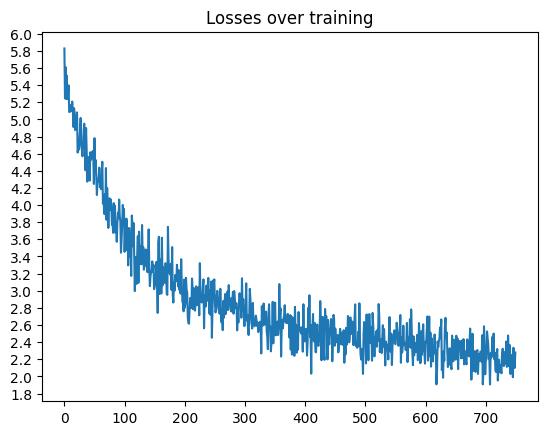

In [67]:
train_iterations(encoder, decoder, 75000, dataset, device, print_every=5000)

## 6. Evaluation

In [68]:
def evaluate(encoder, decoder, input_tensor, dataset, device, max_length=MAX_LENGTH):
    # Eval 모드 설정
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        input_length = input_tensor.size(0)
        # Encoder의 hidden state 초기화
        encoder_hidden = encoder.init_hidden(device=device)

        # encoder_outputs는 Encoder를 통과한 문장의 출력
        # (max_length, hidden_size)
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        # Encoder 에 입력 문자 주입 후 encoder_outputs 생성
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        # Decoder의 첫 번째 입력으로 SOS_TOKEN 입력(SOS_TOKEN=0)
        decoder_input = torch.tensor([[0]], device=device)

        # Decoder의 첫 번째 hidden state는 Encoder의 마지막 hidden state 사용
        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            # 1개의 Decoder 입력 토큰을 통과
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)

            # Attention 시각화를 위한 tensor 저장
            decoder_attentions[di] = decoder_attention.data

            # 출력 토큰 예측
            topv, topi = decoder_output.data.topk(1)

            # EOS_TOKEN이면 종료
            if topi.item() == dataset.EOS_TOKEN:
                decoded_words.append('<EOS>')
                break
            else:
                # 출력 문장에 토큰 시퀀스(index)를 단어(word)로 변환한 후 저장
                decoded_words.append(dataset.wordvocab.index_to_word(topi.item()))

            # decoder_input은 다음 토큰 예측시 입력 값
            # decoder_input: (hidden_size,)
            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]


def evaluate_randomly(encoder, decoder, dataset, device, n=10):
    for i in range(n):
        # 랜덤 샘플링
        x, y = random.choice(dataset)
        # 입력 문장, 출력 문장 (Ground Truth)
        print('>', dataset.sequences_to_texts(x))
        print('=', dataset.sequences_to_texts(y))

        # 예측
        output_words, attentions = evaluate(encoder, decoder, x.to(device), dataset, device)
        output_sentence = ' '.join(output_words)

        # 예측 문장 출력
        print('<', output_sentence)
        print('')

In [69]:
# 랜덤 샘플링 된 데이터 evaluate
evaluate_randomly(encoder, decoder, dataset, device)

> 머리 가 콕콕 쑤셔 <EOS>
= 신경 쓰는 일이 많았나 봅니다 . <EOS>
< 쓰는 일이 쓰는 건 어떨까 요 . <EOS>

> 난 잘못 이 없다 <EOS>
= 천천히 생각 해보세요 . <EOS>
< 천천히 생각 해보세요 . <EOS>

> 사랑 하는데 너무 계산 적 인 여자친구 가 고민 이야 . <EOS>
= 경제 감각 이 없는 것 보다 낫 죠 . <EOS>
< 적극 더 더 싶은 것 도 좋을 거 예요 . <EOS>

> 의미 부여 하면 안되겠지만 <EOS>
= 의미 부여 는 자신 을 더 작게 만들어요 . <EOS>
< 쉬운 을 아니긴 자신 을 . <EOS>

> 소개팅 어플 로 알 게 된 사람 이랑 썸 타도 괜찮을까 ? <EOS>
= 썸 정도 는 괜찮아요 . <EOS>
< 정도 정도 는 정도 괜찮아요 . <EOS>

> 이 젠 기억 이 거의 안나 <EOS>
= 벌써 그러면 안 돼요 . <EOS>
< 벌써 벌써 더 힘들겠어요 . <EOS>

> 사랑 없이 결혼 가능해 ? <EOS>
= 나이 가 들고 그렇게 하기도 하는데 살면서 생기는 정 으로 사는 듯 합니다 . <EOS>
< 인연 해 인연 해 인연 . <EOS>

> 축구 하러 가야 지 <EOS>
= 운동 하고 오세요 . <EOS>
< 운동 하고 오세요 . <EOS>

> 이별 하려다 붙잡고 다시 사귀는데 <EOS>
= 잘 지내길 바랍니다 . <EOS>
< 똑같은 일이 필요한 거 예요 . <EOS>

> 좋아하는데도 헤어지자 네 요 . <EOS>
= 그건 좋아하는 게 아니에요 . <EOS>
< 같은 게 없다면 게 아니에요 . <EOS>



## 7. Attention 가중치 시각화

In [80]:
# 필요 라이브러리 불러오기
import matplotlib.font_manager as fm
import os
import matplotlib.pyplot as plt

# apt-get : 패키지 설치 명령어
# -qq : 에러외의 메세지 숨기는 옵션키
!apt-get -qq install fonts-nanum


fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

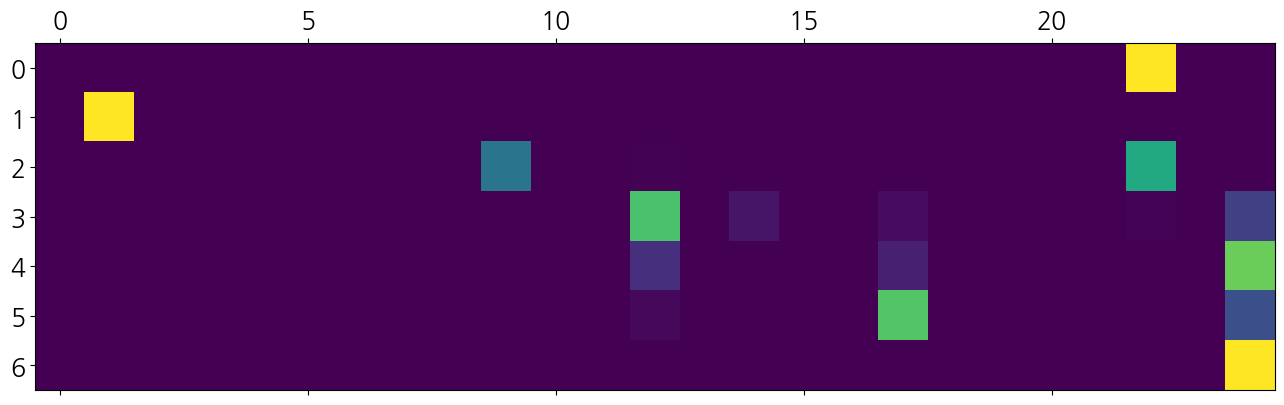

In [81]:
# Attention Weights를 활용한 시각화
output_words, attentions = evaluate(encoder, decoder, dataset[2][0].to(device), dataset, device)
plt.matshow(attentions.numpy())
plt.show()

In [86]:
# Attention 시각화를 위한 함수
def show_attention(input_sentence, output_words, attentions):
    # colorbar로 그림 설정
    fig = plt.figure(figsize=(20,6))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='BuGn')
    fig.colorbar(cax)

    # 축 설정
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # 매 틱마다 라벨 보여주기
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluate_and_show_attention(encoder, decoder, input_sentence, dataset, device):
    output_words, attentions = evaluate(encoder, decoder, input_sentence.to(device), dataset, device)
    input_sentence = dataset.sequences_to_texts(input_sentence)
    output_words = ' '.join(output_words)
    print('input =', input_sentence)
    print('output =', output_words)
    show_attention(input_sentence, output_words.split(), attentions)

input = 3 박 4일 정도 놀러 가고 싶다 <EOS>
output = 여행 좋죠 좋죠 좋죠 좋죠 . <EOS>


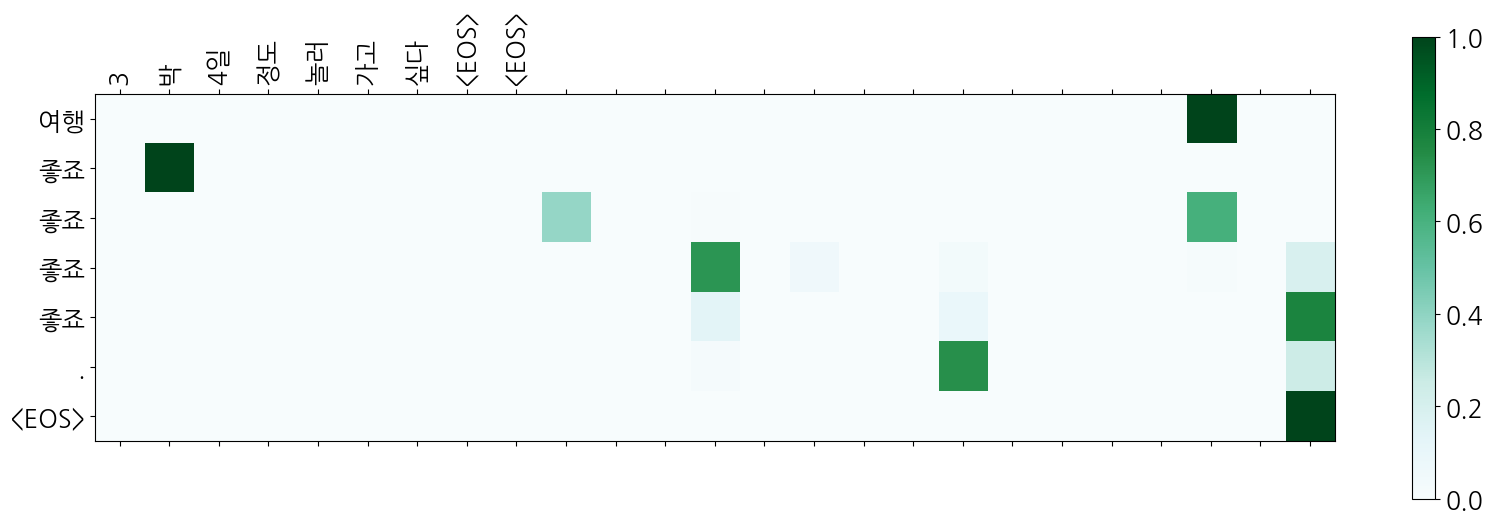

In [87]:
evaluate_and_show_attention(encoder, decoder, dataset[2][0], dataset, device)

##Attention 가중치 시각화 예시

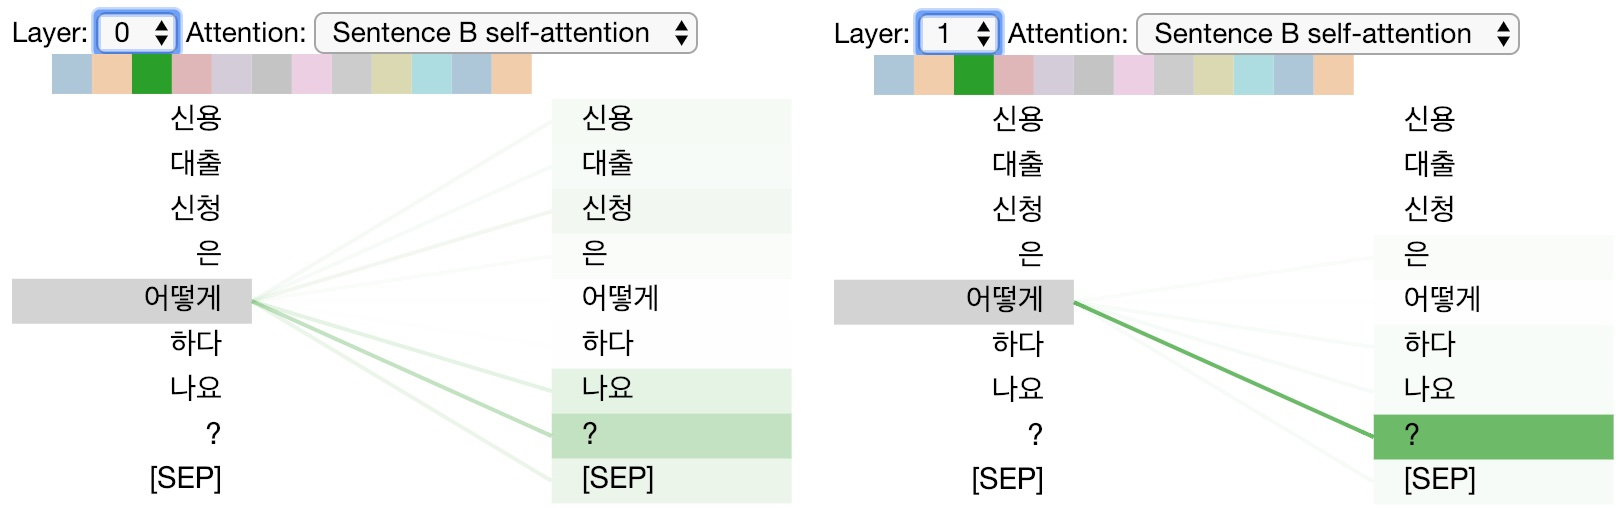

## 과제

정답 여부를 판별하지는 않으니 이해한 바대로 편하게 작성해주시면 됩니다:)

### Q1.RNN의 수식과 구조적 한계를 설명해주세요.

- RNN에서 사용되는 주요 수식은 아래와 같습니다.

1) Hidden Layer

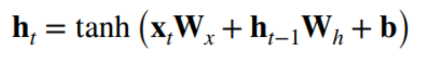

- 해당 수식에서 x(t)는 현 시점의 input을, h(t-1)은 이전 시점의 hidden state 값을 의미하며 W(x)와 W(h)는 각각에 대한 가중치를 의미합니다. 즉, 현재 시점의 hidden state는 현재 입력값과 이전 시점의 hidden state에 가중치 행렬을 각각 곱하고 bias를 더한 값을 tanh 활성화 함수에 적용할 결과라고 이해할 수 있습니다. 

2) Outut Layer

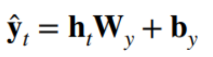

- 최종 output은 앞에서 계산한 현 시점 hidden state 값에 가중치를 곱하고, 편향을 더해 계산할 수 있습니다. 


- RNN의 구조적 한계 
기존 RNN 구조는 기울기 소실 문제와 장기 의존성 문제를 야기한다는 점에서 한계를 가지고 있으며, 이는 tanh 활성화 함수를 사용한 반복적인 연산으로 인해 발생하는 문제입니다. Feed-forward 관점에서는 -1~1 사이의 값을 갖는 tanh 함수의 결과가 hidden state 생성을 위해 지속적으로 곱해지며 뒷단으로 갈수록 앞의 정보를 충분히 유지할 수 없다는 문제가 발생합니다. 더불어,  Back-propagate 관점에서는 0~1 사이의 tanh 미분값이 반복 연산된다는 점에서 시간을 거슬러 올라갈수록 기울기가 점점 작아지는 Gradient vanishing 문제가 발생하고, 결론적으로 가중치가 거의 업데이트되지 않습니다. 

### Q2. '저는 강사 입니다'(one-hot encoded)라는 문장을 encoder의 input으로 받는 seq2seq의 context vector는 어떤 정보를 담고 있으며, 어떠한 특징과 구조를 담고 있는지 이해한 바대로 서술해주세요.

우선, Seq2Seq 모델의 구조를 간략하게 짚고 넘어가겠습니다.

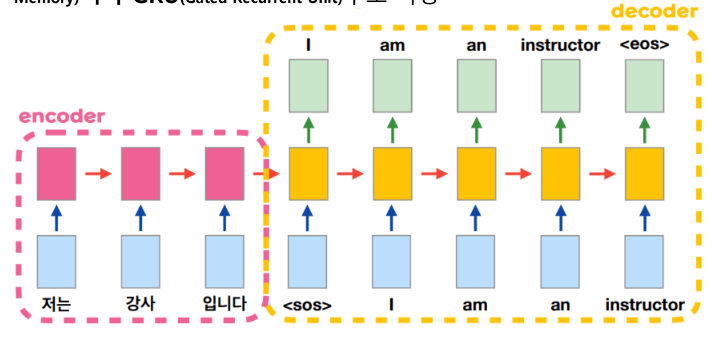

Seq2Seq 모델은 입력 데이터를 인코딩 (임의 길이의 데이터를 고정 길이 벡터로 변환)하는 Encoder와 압축된 context 정보를 바탕으로 출력 sequence를 만드는 Decoder로 이루어져 있습니다. 이 두가지 큰 구성 요소를 이어주는 것은 encoder의 마지막 hidden state인 context vector인데, 이때 context vector는 decoder의 초기 hidden state vector의 역할을 수행하기도 합니다.

그렇다면, context vector는 어떤 정보를 담고 있을까요? context vector는 input으로부터 encoder가 감지할 수 있었던 정보들 - 예를 들어, 문장의 의미나 구조 등 - 이 압축적으로 담겨 있습니다. input의 핵심적인 의미와 정보만 요약해 전달하기 때문에, decoder에서도 적절한 출력을 생성하는 기반이 되는 것입니다.

### Q3. seq2seq의 한계 2가지와 Attention의 기능을 서술해주세요.

1) 기울기 소실 문제
- Seq2Seq은 기본적으로 RNN 계열의 모델 2개를 각각 Encoder-Decoder 역할을 하도록 붙여 둔 것입니다. 이는 결국 RNN 계열의 고질적인 문제인 Gradient vanishing/exploding 문제도 함께 발생할 가능성이 존재한다는 것을 의미합니다.

2) context vector에서의 정보 손실
- encoding은 결국 임의의 길이를 가진 input vector를 고정된 길이의 vector로 변환하는 과정입니다. 이는 곧 문장이 길어질수록 더 많은 정보를 고정된 길이 안에 담아야 하니 정보의 손실이 발생할 수 있음을 의미합니다.  
- 앞서 언급했듯이, Seq2Seq은 RNN 계열의 모델을 사용해 구성되었습니다. 이는 곧, context vector를 만들 때 앞쪽의 정보가 뒷단까지 적용되지 못하는 장기 의존성 문제가 발생할 수 있음을 의미합니다. 결국 context vector에는 마지막 단어의 정보가 가장 뚜렷하게 담기기 때문에 문장의 진짜 문맥이 담겨 있다고 보기 어렵게 되는 것입니다. 

### Q4. RNN + dot-product Attention의 context vector는 어떻게 계산되며, 기존 seq2seq의 context vector와 어떠한 차이가 있는지 서술해주세요.

1. RNN + dot-product Attention의 context vector 계산
- Attention의 핵심은 decoder에서 단어를 예측하는 time step마다 encoder의 전체 문장 중 예측해야 할 단어와 연관이 있는 input 부분을 조금 더 집중해서 본다는 것입니다.
- decoder에서 input 값을 참고해 context vector를 만드는 과정은 다음과 같습니다 :
1) Decoder의 현재 hidden state와 encoder의 모든 hidden state 각각이 얼마나 유사한지를 판단하는 Attention Score를 구합니다. 이 때, attention score는 decoder의 현 시점 hidden state와 encoder의 time step별 hidden state 간의 내적을 통해 구할 수 있습니다. (e^t는 이렇게 구한 각 attention score의 모음입니다.)

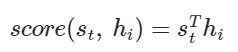
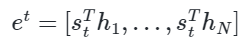

2) e^t (attention score 모음)에 softmax를 적용해 Attention distribution을 구합니다.

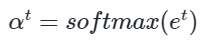

3) softmax를 통해 얻은 attention 가중치와 encoder의 time step별 hidden state를 가중합해 attention 함수의 출력값 = context vector를 구합니다.

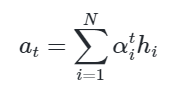

4) attention 함수의 출력값과 decoder의 현 시점 hidden state를 연결해 하나의 벡터로 만들고, 가중치 행렬과의 연산, 활성화 함수 적용을 거쳐 출력층 연산의 입력이 되는 값을 계산합니다.

* 참고 : https://wikidocs.net/22893

2. RNN + dot-product attention vs Seq2Seq
- 기존의 seq2seq에서는 단순하게 encoder의 마지막 hidden state를 context vector로 부르지만, RNN + dot-product attention에서는 디코더의 각 time step마다 context vector를 계산해 사용합니다. 즉, 기본 seq2seq에 비해 decoder의 현 상태에 가장 관련 있는 입력 정보를 반영하게 되는 것입니다. 더불어, attention distribution을 통해 encoder의 각 부분에 가중치를 부여한다는 것 역시 차이가 있습니다. 


### Q5. Self Attention의 등장 배경과 encode와 decoder 각각의 Self Attention 구조를 서술해주세요.

1. Self Attention의 등장 배경
- Self-Attention은 기존의 RNN 계열의 신경망 구조를 탈피하고자 등장한 기법입니다. Encoder의 마지막 hidden state를 context vector로 삼아 문맥 정보를 전달하려던 초기의 seq2seq 방식이 갖는 한계를 극복하기 위해 RNN + Attention을 결합한 모델이 등장했고, attention의 도입은 decoder의 현 시점에 맞는 정보에 주목해 정보 소실 문제를 어느 정도 해결하게 만들어줬습니다. 

그러나, RNN + Attention 모델 역시 여전히 RNN을 사용하고 있었기 때문에 연산 속도가 너무 느리다는 단점이 존재했고, 이에 사람들은 Attention만 사용하는 신경망을 구성할 방법을 찾게 되었습니다. 이 때 등장한 것이 기존의 RNN 구조를 탈피한 Self-attention 기법입니다. 


2. Encoder - Decoder 내에서의 Self Attention

- Self-Attention은 그 이름에서 알 수 있듯이, 자기 자신만을 사용해 Attention 연산을 진행합니다. Self-Attention의 동작 과정에 대해 알아보기 전에, 기존 attention의 연산 과정을 다시 짚어봅시다. Attention 연산을 위해서는 decoder hidden state vector (유사도를 계산하려는 벡터), encoder hidden state vectors (유사도 계산의 대상이 되는 벡터)와 attribute distribution을 이용해 가중합을 구할 수 있는 벡터 총 3개의 벡터가 필요했습니다. 

Encoder와 Decoder의 특정 부분에서 각각의 벡터를 구할 수 있었던 이전 attention 기법과 달리, Self-Attention은 하나의 sequence 안에서 attention 연산에 필요한 3개의 벡터를 모두 만들어야 합니다. 이는 가중치 행렬을 이용한 선형 변환을 토해 생성할 수 있습니다. 

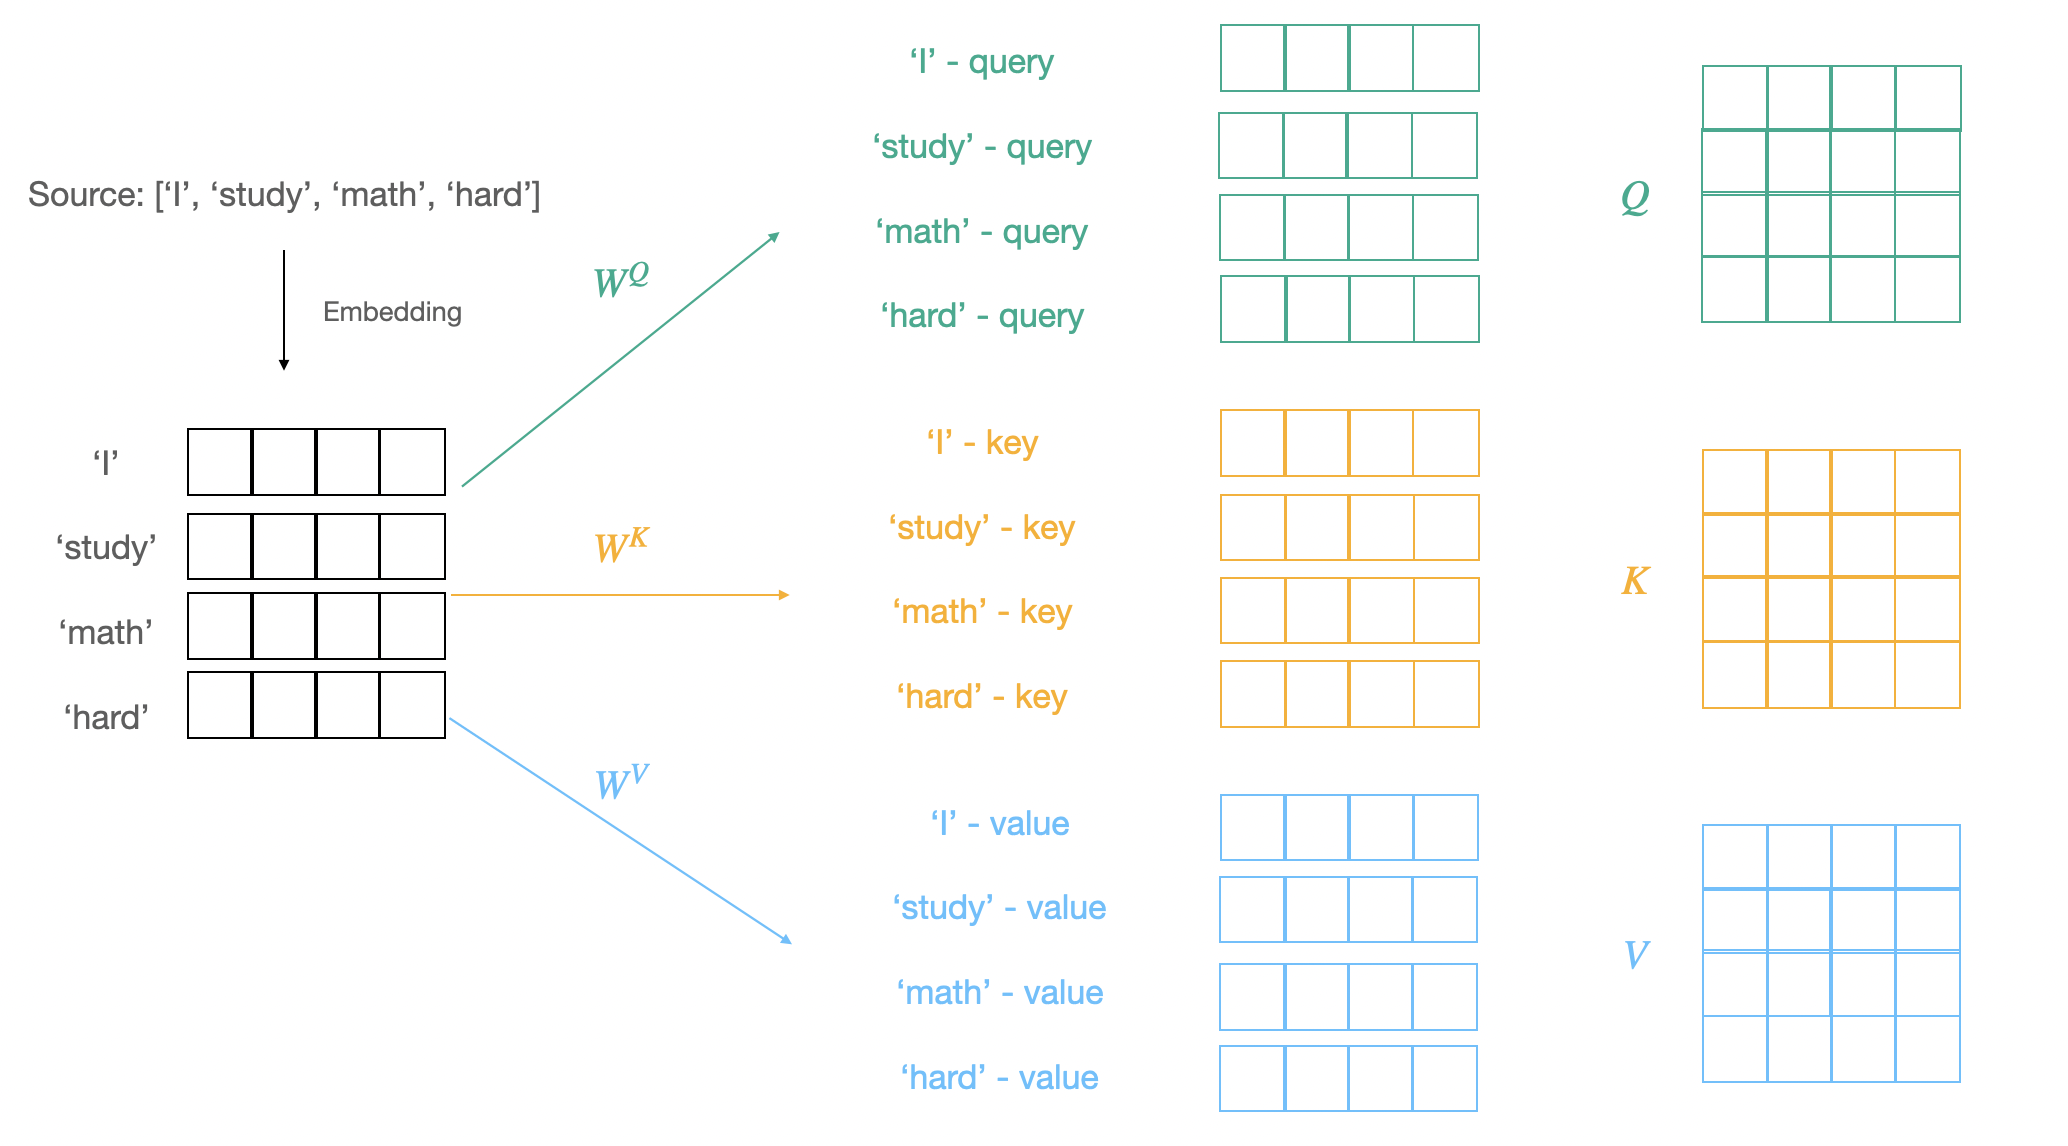

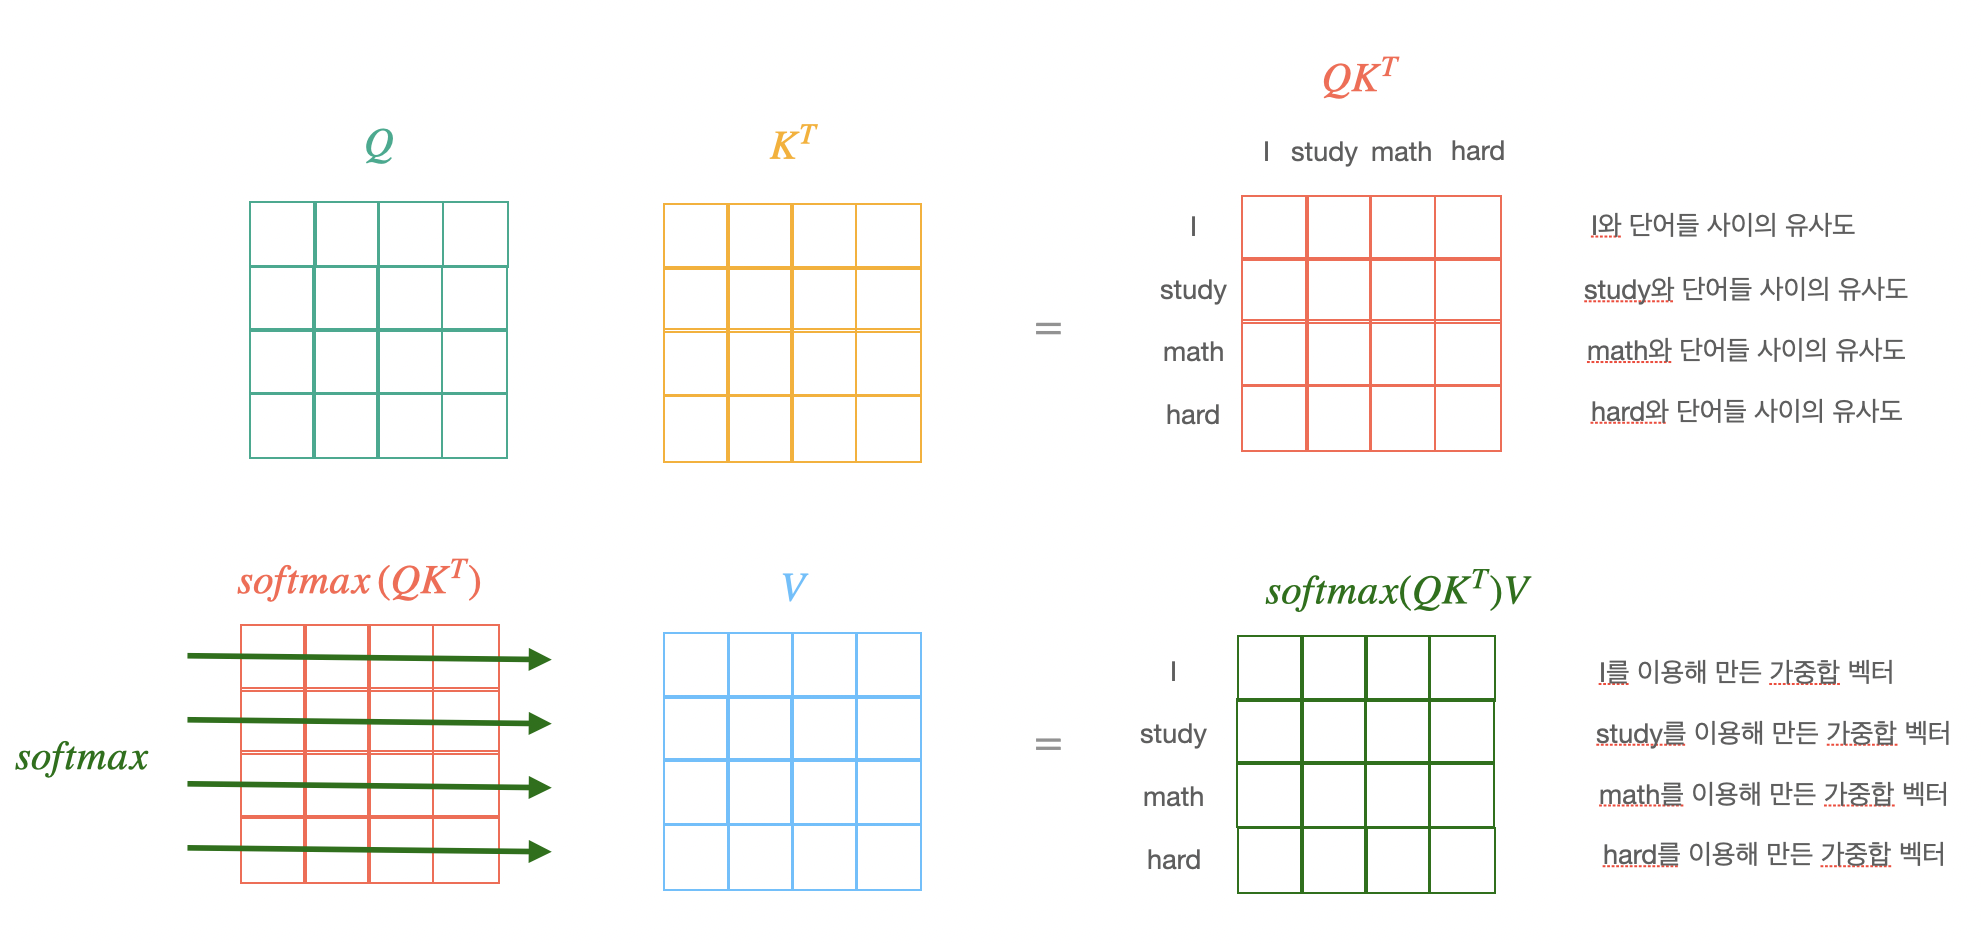

3개의 벡터를 생성한 이후에는, 우리가 attention 연산에서 수행했던 것처럼 dot product attention을 진행하게 됩니다. 

그렇다면 self-attention은 encoder와 decoder 내에서 각각 어떻게 구현되어 있을까요? 

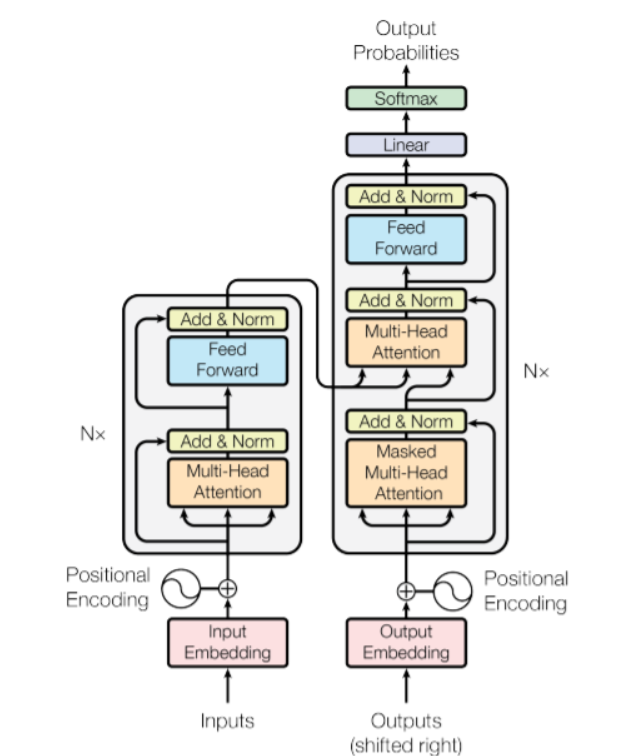

1) Encoder : Encoder는 input에 대한 Embedding과 positional encoding을 마친 뒤 multi-head attention과 feed forward network 레이어를 가진 encoder block을 쌓아 구성됩니다. encoder block에서는 self-attention을 계산하고, scaling 및 softmax 정규화를 거쳐 attention score를 구합니다. 이후 attention score와 각 단어 value를 곱해 context vector를 생성하게 됩니다. 

2) Decoder : 현재 단계 이후의 단어들에 대한 정보는 마스킹하여 현재까지의 단어들을 기반으로 self-attention을 계산합니다. 이는 미래의 정보가 현재 시점에 영향을 미치는 것을 방지하기 위함입니다. 이후에는 encoder의 context vector 정보를 이용해 다음 단어를 예측합니다.  

* 참고 : https://velog.io/@nkw011/transformer

### Q6. 왜 "Attention is All You Need."라는 논문 제목이 등장하게 되었는지 이해한 바대로 자유롭게 작성해주세요.

RNN부터 LSTM, Seq2Seq과 RNN + Attention 등 sequence 데이터를 처리하기 위한 모델은 나름의 방식으로 발전을 거듭했으나 RNN 계열만을 활용하며 RNN이 갖는 본질적인 문제들을 답습해 왔습니다. RNN 계열 모델의 한계인 장기 의존성 문제 (앞쪽 정보의 소실)와 병렬 처리의 어려움은 긴 텍스트 데이터를 처리하는 데 있어 큰 문제가 되는만큼, 높은 성능과 유용성을 확보하기 위해서는 RNN 구조를 탈피해 새로운 해결책을 제시할 필요가 있었습니다.

특정한 부분에 집중해 문맥을 보다 잘 파악할 수 있게 해준 Attention 매커니즘과, RNN 구조 자체를 탈피할 수 있게 한 Self-Attention 매커니즘의 등장은 이런 상황에서 가히 혁신적이었으리라 생각합니다. Self-Attention과 Transformers의 등장으로 시퀀스 데이터 처리의 효율성과 효과가 극대화되었고, 기존 모델들의 한계가 극복되었기에 더이상 기존의 모델과 자잘한 문제들에 대해서는 생각할 필요가 없다 ! 이제 Attention과 이로부터의 발전에만 집중하면 된다! 라는 뜻에서 "Attention is All You Need"라는 제목이 나왔다고 생각합니다. 